['fer2013.bib', 'fer2013.csv', 'README', 'train', 'validation']
Train Classes - ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
Validation Classes - ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


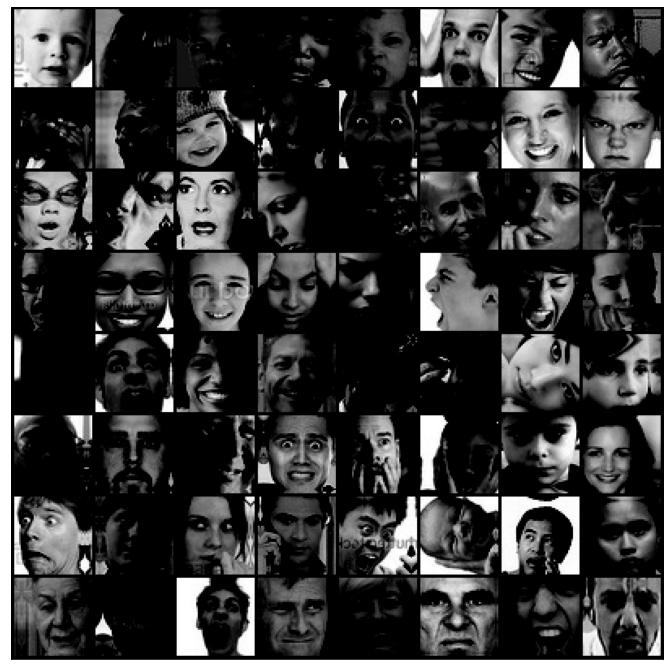

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon May 10 15:02:09 2021

@author: smith_barbose @neb.tics

download the dataset from https://www.kaggle.com/dataset/de270025c781ba47a3a6d774a0d670452bfb4dc9d2d6b13740cdb0c17aa7bf2b

"""


import os
import torch
import torchvision
import torch.nn as nn
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Looking into the directory
data_dir = r'C:\Users\s\Documents\Nebtics\Datasets\Emotions\fer2013'
print(os.listdir(data_dir))
classes_train = os.listdir(data_dir + "/train")
classes_valid = os.listdir(data_dir + "/validation")
print(f'Train Classes - {classes_train}')
print(f'Validation Classes - {classes_valid}')

'''Data transforms (Gray scaling and data augmentation'''
train_trams=tt.Compose([tt.Grayscale(num_output_channels=1),tt.RandomCrop(48,padding=4,padding_mode='reflect'),
                        tt.RandomHorizontalFlip(),tt.ToTensor(),tt.Normalize((0.5),(0.5),inplace=True)])
#test
test_trams=tt.Compose([tt.Grayscale(num_output_channels=1),
                        tt.ToTensor(),tt.Normalize((0.5),(0.5),inplace=True)])

'''Emotion detection datasets loading'''
train_ds=ImageFolder(data_dir+'/train',train_trams)
test_ds=ImageFolder(data_dir+'/validation',test_trams)

batch_size=400

'''Creating the traning and test set'''

train_dataloader=DataLoader(train_ds,batch_size,shuffle=True,num_workers=0,pin_memory=True)
test_dataloader=DataLoader(test_ds,batch_size*2,num_workers=0,pin_memory=True)

def show_batch(dl):
    for images,labels in dl:
        fig,ax=plt.subplots(figsize=(12,12))
        ax.set_xticks([]);ax.set_yticks([])
        ax.imshow(make_grid(images[:64],nrow=8).permute(1,2,0))
        break

#%%
show_batch(train_dataloader)


In [2]:
#using GPU 
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)
class Devicedataloader():
    def __init__(self,dl,device):
        self.dl=dl
        self.device=device
    def __iter__(self):
        for b in self.dl:
            yield to_device(b,self.device)
    def __len__(self):
        return len(self.dl)
    

In [3]:
device=get_default_device()
device

device(type='cuda')

In [4]:
train_dataloader=Devicedataloader(train_dataloader,device)
test_dataloader=Devicedataloader(test_dataloader,device)


In [5]:
#traning steps creation
def accuracy(outputs,labels):
    _,preds=torch.max(outputs,dim=1)
    return torch.tensor(torch.sum(preds == labels).item()/len(preds))
class Imageclassification(nn.Module):
    def training_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        return loss
    
    def validation_step(self,batch):
        images,labels=batch
        out=self(images)
        loss=F.cross_entropy(out,labels)
        acc=accuracy(out,labels)
        return {'val_loss': loss.detach(),'val_acc':acc}
    
    def validation_epoch_end(self,outputs):
        batch_losses=[x['val_loss'] for x in outputs ]
        epoch_loss=torch.stack(batch_losses).mean()
        batch_acc=[x['val_acc'] for x in outputs ]
        epoch_acc=torch.stack(batch_acc).mean()
        return {'val_loss':epoch_loss.item(),'val_acc':epoch_acc.item()}
    def epoch_end(self,epoch,result):
            print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))
        
        

In [6]:
'''Building the model'''
#creating a function as conv_block and making layers as a list 
def conv_block(in_channels,out_channels,pool= False):
    layers=[nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Dropout2d(0.25)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
    
class Resnet(Imageclassification):
    def __init__(self,in_channels,num_classes):
        super().__init__()
        self.conv1=conv_block(in_channels,64,pool=True)
        self.conv2=conv_block(64,128,pool=True)
        self.res1=nn.Sequential(conv_block(128,128),conv_block(128,128))
        self.conv3=conv_block(128,256,pool=True)
        self.conv4=conv_block(256,512,pool=True)
        self.res2=nn.Sequential(conv_block(512,512),conv_block(512,512))
        self.classifier=nn.Sequential(nn.AvgPool2d(3),
                                     nn.Flatten(),
                                     nn.Linear(512,64),
                                     nn.Linear(64,num_classes),
                                     nn.Softmax(dim=1))
        
    def forward(self,xb):
        out=self.conv1(xb)
        out=self.conv2(out)
        out=self.res1(out)+out

        out=self.conv3(out)
        out=self.conv4(out)
        out=self.res2(out)+out
        
        out= self.classifier(out)
        return out

In [7]:
model = to_device(Resnet(1,len(classes_train)),device)
model

Resnet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Dropout2d(p=0.25, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope

In [22]:
@torch.no_grad() #stoping the SGD
def evaluate(model,val_loader):
    model.eval()
    outputs=[model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
def fit_one_cycle(epoch,max_lr,model,train_loader,val_loader,grad_clip=None,opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history=[]
    optimizer=opt_func(model.parameters(),max_lr)
    sched=torch.optim.lr_scheduler.OneCycleLR(optimizer,max_lr,epochs=epochs,steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        #traning phase
        model.train()
        train_losses=[]
        lrs=[]
        for batch in train_loader:
            loss=model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            #gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(),grad_clip)
            optimizer.step()
            optimizer.zero_grad()
            #record and update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        result=evaluate(model,val_loader)
        result['train_loss']=torch.stack(train_losses).mean().item()
        result['lrs']=lrs
        model.epoch_end(epoch,result)
        history.append(result)
    return history


In [23]:
evaluate(model,test_dataloader)

{'val_loss': 1.946270227432251, 'val_acc': 0.17651671171188354}

In [24]:
epochs = 30
max_lr = 0.001
grad_clip = 0.2

In [25]:
%%time
history = fit_one_cycle(epochs, max_lr, model, train_dataloader, test_dataloader, grad_clip=grad_clip)

Epoch [0], last_lr: 0.00007, train_loss: 1.8987, val_loss: 1.8988, val_acc: 0.2282
Epoch [1], last_lr: 0.00015, train_loss: 1.8778, val_loss: 1.8918, val_acc: 0.2322
Epoch [2], last_lr: 0.00028, train_loss: 1.8396, val_loss: 1.8327, val_acc: 0.3104
Epoch [3], last_lr: 0.00044, train_loss: 1.7749, val_loss: 1.7298, val_acc: 0.4241
Epoch [4], last_lr: 0.00060, train_loss: 1.7446, val_loss: 1.7517, val_acc: 0.3985
Epoch [5], last_lr: 0.00076, train_loss: 1.7246, val_loss: 1.7139, val_acc: 0.4347
Epoch [6], last_lr: 0.00089, train_loss: 1.7158, val_loss: 1.7492, val_acc: 0.4056
Epoch [7], last_lr: 0.00097, train_loss: 1.6972, val_loss: 1.7086, val_acc: 0.4496
Epoch [8], last_lr: 0.00100, train_loss: 1.6824, val_loss: 1.6875, val_acc: 0.4656
Epoch [9], last_lr: 0.00099, train_loss: 1.6731, val_loss: 1.6708, val_acc: 0.4879
Epoch [10], last_lr: 0.00098, train_loss: 1.6656, val_loss: 1.6696, val_acc: 0.4843
Epoch [11], last_lr: 0.00095, train_loss: 1.6587, val_loss: 1.6853, val_acc: 0.4729
Ep

In [26]:

def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

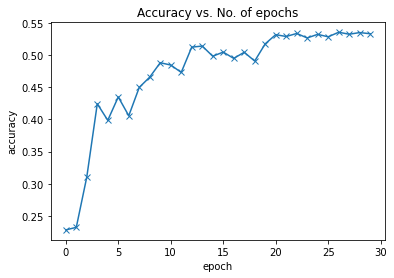

In [28]:
plot_accuracies(history)



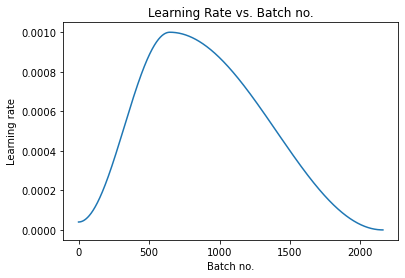

In [29]:
plot_lrs(history)

In [32]:
torch.cuda.empty_cache()